In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/0f72db9c-d635-4415-9781-68937328aed2___NREC_B.Spot 9188.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/1b8d3e98-43d9-441d-93ef-a359e6e9ddc2___NREC_B.Spot 9052.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/b6d35d21-4812-4e32-ab9a-b6ddda8cbb79___JR_B.Spot 8972.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/e4e7e5a2-5aa1-4378-833d-9142358c7c9b___JR_B.Spot 9092.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/8b50f2db-cbf2-4758-bea6-a011f0cc1497___JR_B.Spot 3235.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/729b55d7-2a99-4861-910d-3b4e2bbce13a___JR_B.Spot 9036.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/4614ed01-e120-4ae9-8f13-028fa8297873___JR_B.Spot 8985.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/b143a281-5395-4a2a-830

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import os

# to disable all debugging logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
#importing data set
dir = os.listdir('../input/plant-village/PlantVillage')
for filenames in dir:
    print(filenames)

Pepper__bell___Bacterial_spot
Potato___healthy
Tomato_Leaf_Mold
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato_Bacterial_spot
Tomato_Septoria_leaf_spot
Tomato_healthy
Tomato_Spider_mites_Two_spotted_spider_mite
Tomato_Early_blight
Tomato__Target_Spot
Pepper__bell___healthy
Potato___Late_blight
Tomato_Late_blight
Potato___Early_blight
Tomato__Tomato_mosaic_virus


**Extracting Potato Dataset from PlantVillage**

In [4]:
!cp -rf ../input/plant-village/PlantVillage/Potato___Early_blight ./Potato___Early_blight

In [5]:
!cp -rf ../input/plant-village/PlantVillage/Potato___Late_blight ./Potato___Late_blight

In [6]:
!cp -rf ../input/plant-village/PlantVillage/Potato___healthy ./Potato___healthy

In [7]:
Current_Dir = os.getcwd()
dataset_dir = pathlib.Path(Current_Dir)
print(dataset_dir)

/kaggle/working


In [8]:
#Global initialization of some variables
Image_Size = 256
Batch_Size = 32
Channels = 3
EPOCHS = 50

In [9]:
# Pipeline Initialization
dataset = tf.keras.preprocessing.image_dataset_from_directory(
dataset_dir,
shuffle=True,
image_size=(Image_Size, Image_Size),
batch_size=Batch_Size
)

Found 2152 files belonging to 3 classes.


In [10]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
len(dataset)

68

In [12]:
# Explore a single batch
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 0 2 0 0 1 0 0 0 0 0 0 0 2 0 0 1 1 1 1 0 1 0 1 0 1 1 0 1 0 0]


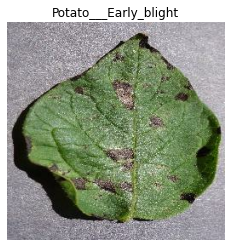

In [13]:
# Explore an Image
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.axis('off')
    plt.title(class_names[label_batch[0]])
    

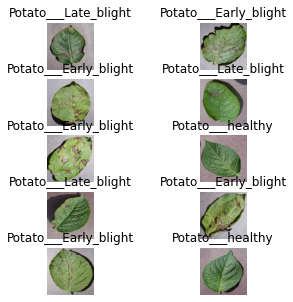

In [14]:
# Explore Your Images
plt.figure(figsize=(5,5))
for image_batch, label_batch in dataset.take(1):
    for i in range(10):
        plt.subplot(5,2,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

In [15]:
# 80% ==> training
# 10% ==> val
# 10% ==> test

In [16]:
train_ds = dataset.take(54)
len(train_ds)

54

In [17]:
testval_ds = dataset.skip(54)
len(testval_ds)

14

In [18]:
val_ds = testval_ds.take(7)
test_ds = testval_ds.skip(7)
len(val_ds),len(test_ds)

(7, 7)

In [19]:
# Function for Splitting the data
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)
        
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [20]:
train, val, test = split_dataset(dataset)

In [21]:
len(train),len(val),len(test)

(54, 6, 8)

In [22]:
# caching,shuffle and prefetching the data
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
# Image Preprocessing Process: Rescaling and Resizing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [24]:
# Data augmentation 
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(factor = 0.2)
])

In [25]:
input_shape=(Batch_Size, Image_Size, Image_Size, Channels)
n_classes=3
model =  models.Sequential([
    resize_and_rescale,
    data_augmentation,
#     CNN
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
#     ANN
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
    
])

model.build(input_shape = input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [27]:
model.compile(
    optimizer = 'adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
    metrics = ['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

In [28]:
history = model.fit(
    train, 
    epochs = EPOCHS, 
    batch_size = Batch_Size, 
    verbose = 1, 
    validation_data = val
)


Epoch 1/50
54/54 [==============================] - 14s 79ms/step - loss: 0.8748 - accuracy: 0.4888 - val_loss: 0.7911 - val_accuracy: 0.6406
Epoch 2/50
54/54 [==============================] - 2s 37ms/step - loss: 0.6819 - accuracy: 0.6761 - val_loss: 0.7215 - val_accuracy: 0.6875
Epoch 3/50
54/54 [==============================] - 2s 35ms/step - loss: 0.4887 - accuracy: 0.7905 - val_loss: 0.4621 - val_accuracy: 0.7865
Epoch 4/50
54/54 [==============================] - 2s 35ms/step - loss: 0.3869 - accuracy: 0.8445 - val_loss: 0.5504 - val_accuracy: 0.7604
Epoch 5/50
54/54 [==============================] - 2s 35ms/step - loss: 0.3507 - accuracy: 0.8586 - val_loss: 0.2534 - val_accuracy: 0.8698
Epoch 6/50
54/54 [==============================] - 2s 35ms/step - loss: 0.2704 - accuracy: 0.8944 - val_loss: 0.2774 - val_accuracy: 0.8906
Epoch 7/50
54/54 [==============================] - 2s 35ms/step - loss: 0.2026 - accuracy: 0.9202 - val_loss: 0.1598 - val_accuracy: 0.9375
Epoch 8/50
5

In [29]:
scores = model.evaluate(test)

8/8 [==============================] - 2s 14ms/step - loss: 0.0135 - accuracy: 0.9922


In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**Analysing Output**

In [33]:
# Getting the model history parameters

train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

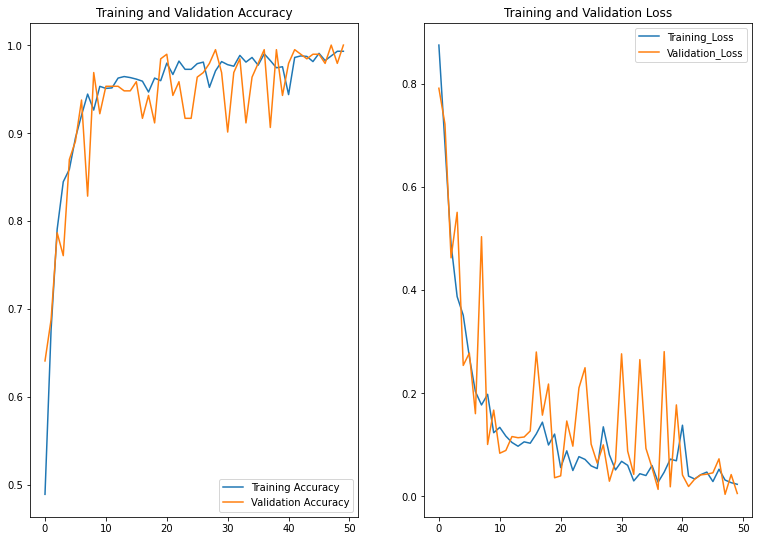

In [38]:
#graphs showing accuracy and loss of training and validation data

plt.figure(figsize = (20,20))
plt.subplot(2,3,1)
plt.plot(range(EPOCHS), train_acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2,3,2)
plt.plot(range(EPOCHS), train_loss, label = 'Training_Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation_Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

First Image to Predict
Actual lmage Label :  Potato___Early_blight
Predicted Label:  Potato___Early_blight


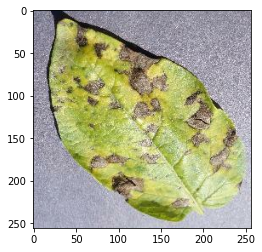

In [43]:
for image_batch, label_batch in test.take(1):
    first_img = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print('First Image to Predict')
    plt.imshow(first_img)
    print('Actual lmage Label : ', class_names[first_label])
    batch_prediction = model.predict(image_batch)
    print('Predicted Label: ', class_names[np.argmax(batch_prediction[0])])

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

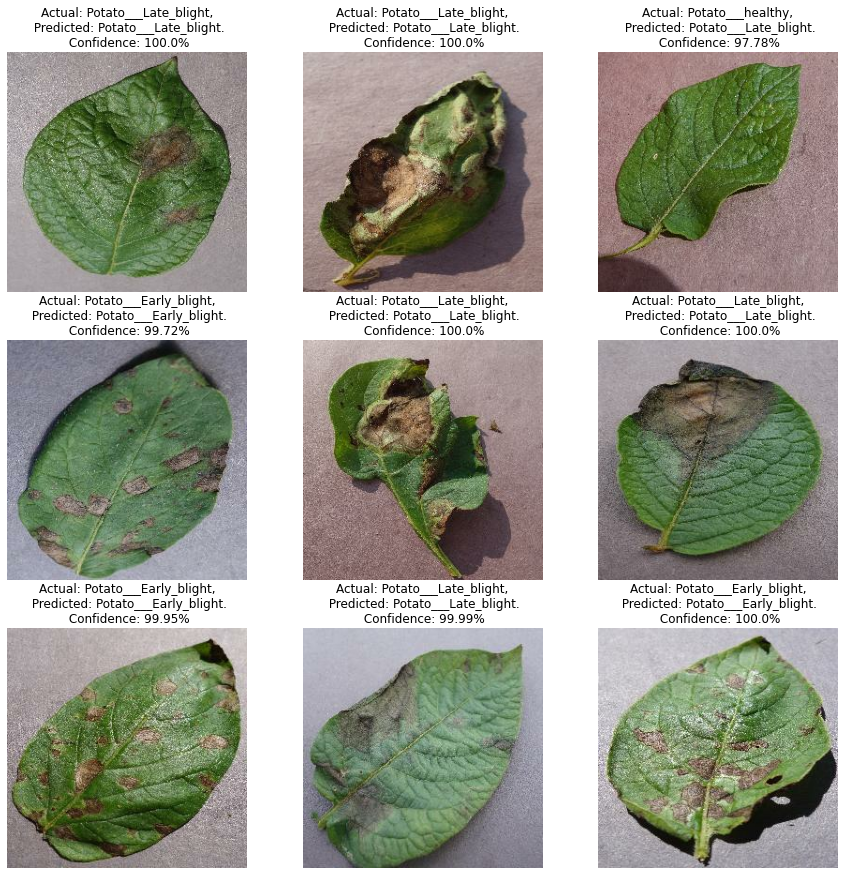

In [45]:
# plotting batch of images with its actual label, predicted label and confidence
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")